# Look at the Free State covid waves using empirical mode decomposition (EMD)

In [143]:
import pandas as pd
import numpy as np
from scipy import signal, ndimage
import matplotlib.pyplot as plt
import seaborn as sns
import emd


To get some background of this method this video does a good job:

https://www.youtube.com/watch?v=cJXRFZhHcrI

8:30 minutes if is probably a good place to start.  The paper linked to later is also a good source.

### Load the data and plot the total tested and rate data

In [2]:
data = pd.read_pickle("../rates_and_clusters/ratesClusters_filled_days.pkl")
#data = data[['cluster', 'AllDates', 'INCONCLUSIVE', 'NEGATIVE', 'POSITIVE']]
fsDf = data.groupby('AllDates')[['INCONCLUSIVE', 'NEGATIVE', 'POSITIVE', 'Total']].sum()
fsDf['rate'] = fsDf['POSITIVE'] / fsDf['Total'] *100
fsDf.fillna(0, inplace=True)# Fillna, this is for deviding by zero
fsDf.reset_index(inplace=True)

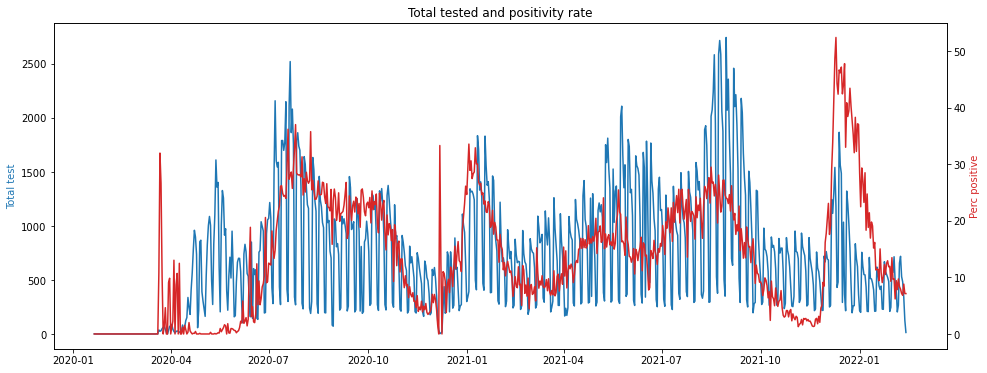

In [3]:
fig, ax1 = plt.subplots(figsize=(16,6))
ax1.plot(fsDf['AllDates'], fsDf['Total'], 'tab:blue')
ax1.set_ylabel('Total test', color='tab:blue')
ax2 = ax1.twinx()
ax2.plot(fsDf['AllDates'], fsDf['rate'], 'tab:red')
ax2.set_ylabel('Perc positive', color='tab:red')
plt.title('Total tested and positivity rate')
plt.show()

#### Noise assisted sifting with ensemble sifting

Found at: https://emd.readthedocs.io/en/stable/emd_tutorials/01_sifting/emd_tutorial_01_sift_03_ensemblesift.html#

*One solution to these issues is to try and normalise the amount of noise through a signal by adding a small amount of white noise to the signal before sifting. We do this many times, creating an ensemble of sift processes each with a separate white noise added. The final set of IMFs is taken to be the average across the whole ensemble.*

*This might seem like an odd solution. It relies on the effect of the additive white noise cancelling out across the whole ensemble, whilst the true signal (which is present across the whole ensemble) should survive the averaging.*

This paper also explains it very well:  https://www.sciencedirect.com/science/article/pii/S1876610216309729

 Inputs samples (755) is small for specified max_imfs (10) very likely that 8 or fewer imfs are returned


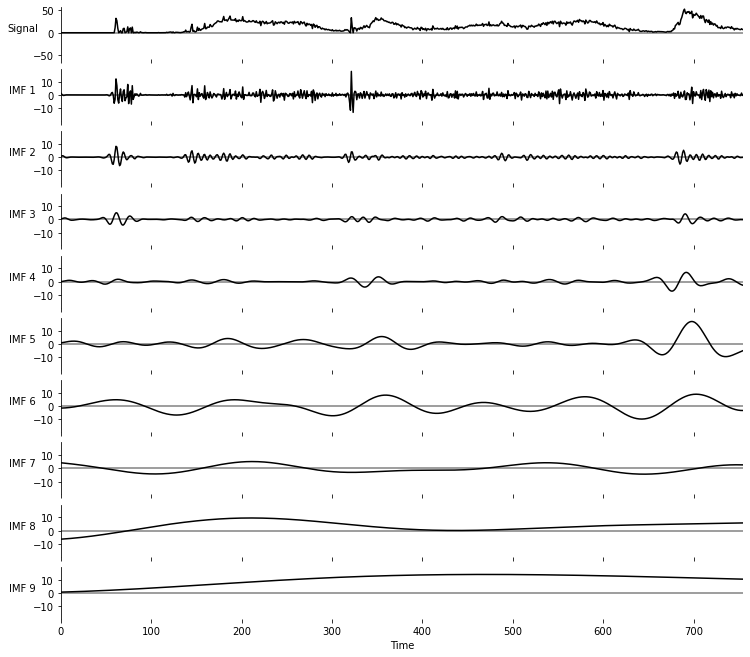

In [4]:
x = fsDf['rate'].values

fig = plt.figure(figsize=(12,10))
#imf = emd.sift.ensemble_sift(x, max_imfs=8, nensembles=100, nprocesses=8, ensemble_noise=0.5)
imf = emd.sift.mask_sift(x, max_imfs=10)
emd.plotting.plot_imfs(imf, cmap=False, scale_y=True, fig=fig)

The figure above shows the raw signal at the top (positivity rate), and that is followed by the IMFs (intrinsic mode functions) which is the term used for the monocomponent functions.  Looking at IMF1 and IMF2, these seem to be mostly noise due to sampling, lab turn around times and reporting delays.  We can remove these 2 components and add the rest of the components together to reconstruct the raw wave to see how well we can recontruct it again.  

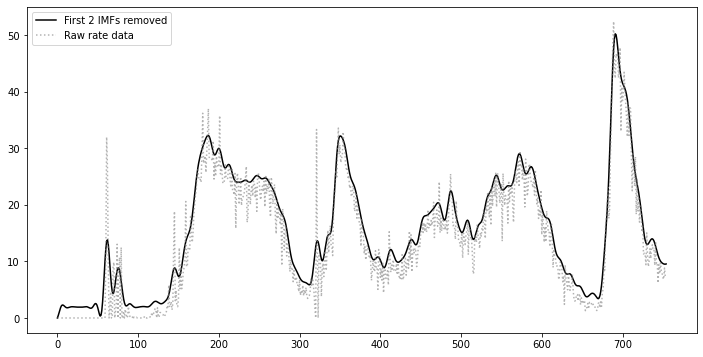

In [5]:
smooth = np.zeros(imf.shape[0])       # initialize an array of zeros with the same lenght of our imf arrays
for i in np.arange(2, imf.shape[1]):  # loop through our imf arrays and add the values cumalatively
    smooth += imf[:, i]

# plot the resulting reconstruction
plt.figure(figsize=(12,6))
plt.plot(smooth + abs(smooth.min()), label='First 2 IMFs removed', color='black')  #smooth which is the sum of the used imfs is 'raised' with the
plt.plot(x, ':', alpha=0.6, label='Raw rate data', color='grey')                   #minimum to raise it to the level of the signal.  
plt.legend()
plt.show()


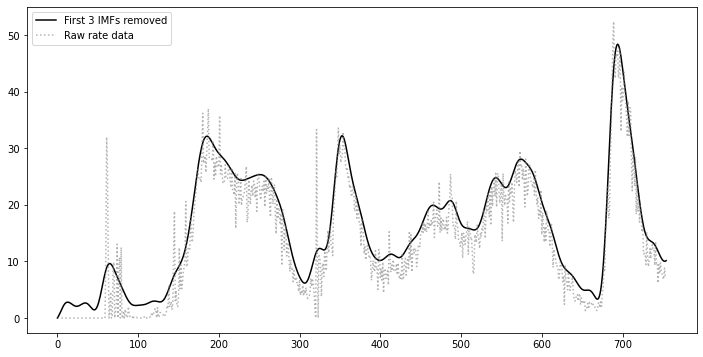

In [197]:
smooth = np.zeros(imf.shape[0])       
for i in np.arange(3, imf.shape[1]):  
    smooth += imf[:, i]

# plot the resulting reconstruction
plt.figure(figsize=(12,6))
plt.plot(smooth + abs(smooth.min()), label='First 3 IMFs removed', color='black')  
plt.plot(x, ':', alpha=0.6, label='Raw rate data', color='grey')                   
plt.legend()
plt.show()

---
# Hilbert Haung

### 1d frequency tranform

In [27]:
sample_rate = 1 # does this mean daily
IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate=sample_rate, method='nht')

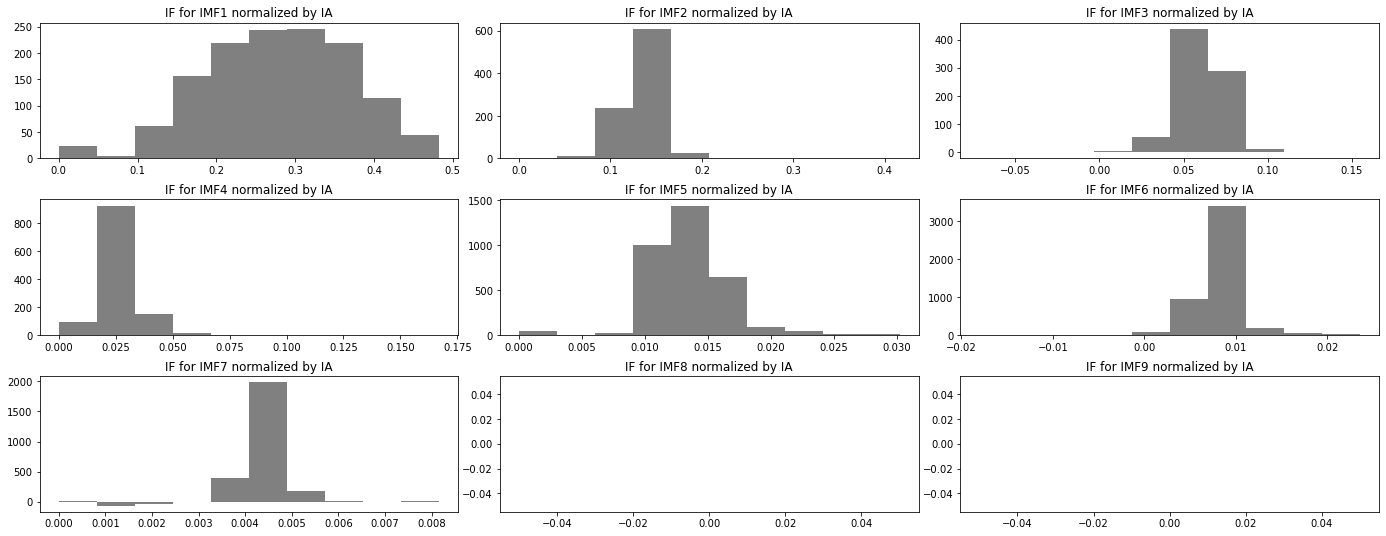

In [9]:
fig, ax = plt.subplots(3,3, figsize=(24, 9), facecolor='w', edgecolor='k')
fig.subplots_adjust(wspace=0.1, hspace=0.3)

ax = ax.ravel()

for i in range(0, IF.shape[1]):
    
    ax[i].hist(IF[:, i], color='gray', weights=IA[:, i], histtype='bar')
    ax[i].set_title(f'IF for IMF{i+1} normalized by IA')


plt.show()


In [23]:
freq_edges, freq_centres = emd.spectra.define_hist_bins(0, 0.5, len(x)*2)

In [28]:
# Amplitude weighted HHT per IMF
f, spec_weighted = emd.spectra.hilberthuang(IF, IA, freq_edges, sum_imfs=False)

# Unweighted HHT per IMF - we replace the instantaneous amplitude values with ones
f, spec_unweighted = emd.spectra.hilberthuang(IF, np.ones_like(IA), freq_edges, sum_imfs=False)

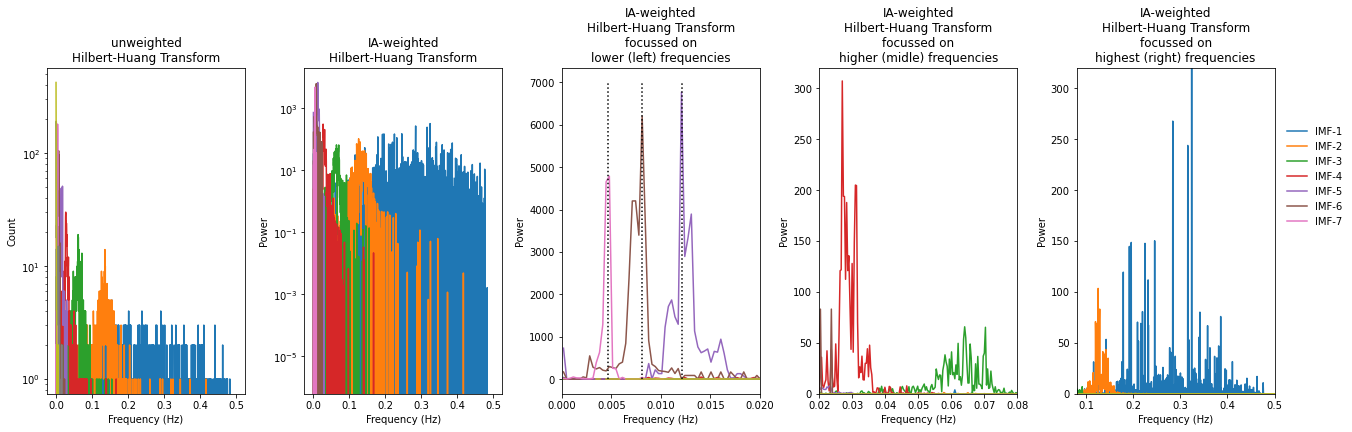

In [51]:
plt.figure(figsize=(22, 6))
plt.subplots_adjust(wspace=0.3)
plt.subplot(151)
plt.plot(freq_centres, spec_unweighted)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Count')
plt.yscale('log')
plt.title('unweighted\nHilbert-Huang Transform')

plt.subplot(152)
plt.plot(freq_centres, spec_weighted)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.yscale('log')
plt.title('IA-weighted\nHilbert-Huang Transform')

plt.subplot(153)
plt.plot(freq_centres, spec_weighted)
plt.xlabel('Frequency (Hz)')
plt.xlim(0, 0.02)
plt.vlines(x=[0.0047, 0.0081, 0.0121], ymin=0, ymax=7000, ls=":", color='black')
plt.ylabel('Power')
plt.title('IA-weighted\nHilbert-Huang Transform\nfocussed on\nlower (left) frequencies')

plt.subplot(154)
plt.plot(freq_centres, spec_weighted)
plt.xlabel('Frequency (Hz)')
plt.xlim(0.02, 0.08)
plt.ylim(0, 320)
plt.ylabel('Power')
plt.title('IA-weighted\nHilbert-Huang Transform\nfocussed on\nhigher (midle) frequencies')

plt.subplot(155)
plt.plot(freq_centres, spec_weighted)
plt.xlabel('Frequency (Hz)')
plt.xlim(0.08, 0.5)
plt.ylim(0, 320)
plt.ylabel('Power')
plt.legend(['IMF-1', 'IMF-2', 'IMF-3', 'IMF-4', 'IMF-5', 'IMF-6', 'IMF-7'], frameon=False, loc=(1.04,0.5))
plt.title('IA-weighted\nHilbert-Huang Transform\nfocussed on\nhighest (right) frequencies')

plt.show()



### 2d

#### Plot HHT for each IMF seperately setting color such that all are visible, setting vmax = 0.1

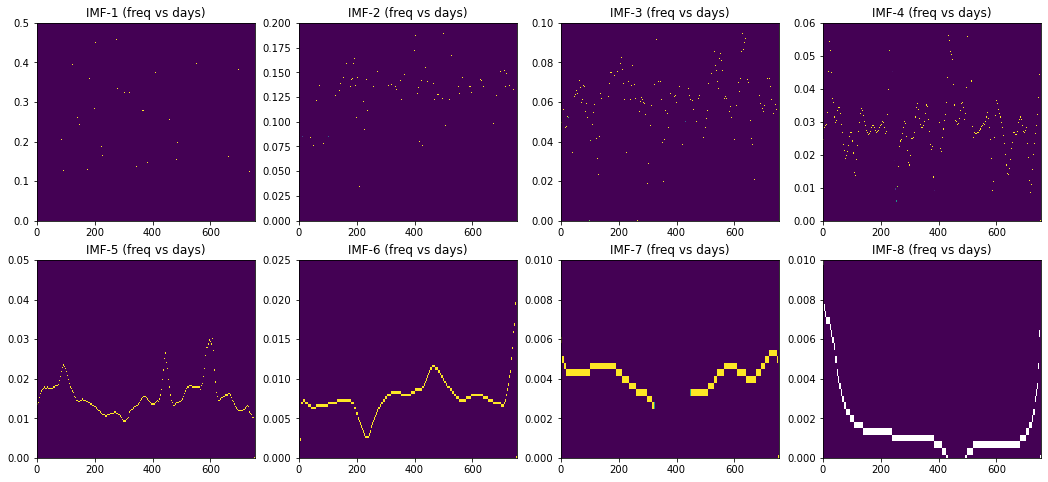

In [208]:
fig, axs = plt.subplots(2,4, figsize=(18, 8), facecolor='w', edgecolor='k', sharey=False)
fig.subplots_adjust(hspace = .2, wspace=.2)

axs = axs.ravel()
ymax = [0.5, 0.2, 0.1, 0.06, 0.05, 0.025, 0.01, 0.01]
for i in range(8):
    # Plot HHT
    f, hht = emd.spectra.hilberthuang(IF[:, i, None], IA[:, i, None], freq_edges, mode='amplitude', sum_time=False) # now sum_time =False, 1d sum_imfs = false
    time_centers = np.arange(len(x))-0.5
    axs[i].pcolormesh(time_centers, freq_edges[0:-1], hht[:, :len(time_centers)], cmap='viridis', vmin=0, vmax=0.1)
    axs[i].set_ylim(0, ymax[i])
    axs[i].set_title(f'IMF-{i+1} (freq vs days)')

#### Not setting max colour value

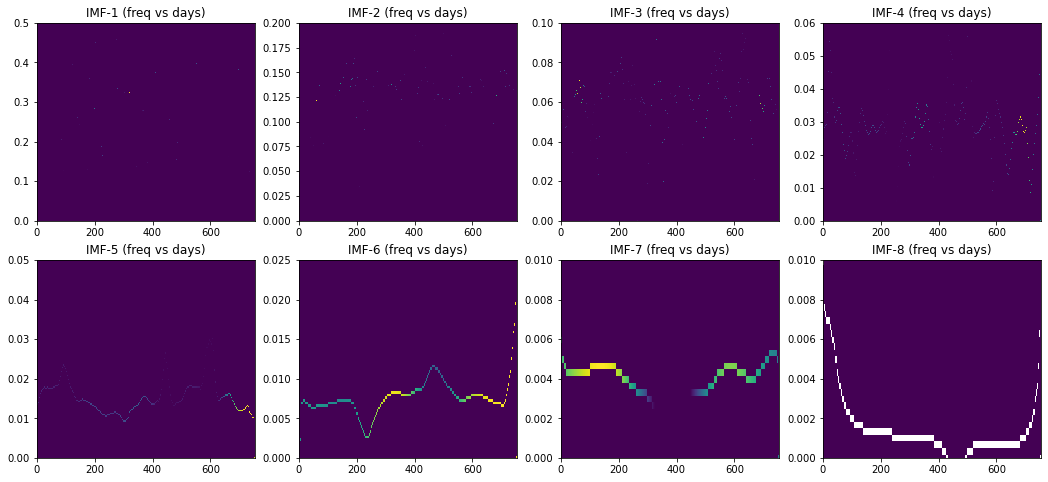

In [209]:
fig, axs = plt.subplots(2,4, figsize=(18, 8), facecolor='w', edgecolor='k', sharey=False)
fig.subplots_adjust(hspace = .2, wspace=.2)

axs = axs.ravel()
ymax = [0.5, 0.2, 0.1, 0.06, 0.05, 0.025, 0.01, 0.01]
for i in range(8):
    # Plot HHT
    f, hht = emd.spectra.hilberthuang(IF[:, i, None], IA[:, i, None], freq_edges, mode='amplitude', sum_time=False) # now sum_time =False, 1d sum_imfs = false
    time_centers = np.arange(len(x))-0.5
    axs[i].pcolormesh(time_centers, freq_edges[0:-1], hht[:, :len(time_centers)], cmap='viridis', vmin=0)
    axs[i].set_ylim(0, ymax[i])
    axs[i].set_title(f'IMF-{i+1} (freq vs days)')

From the above plots we can see that there is very little contrubution from IMFs 1 to 4.  We can reconstruct the data using IMFs 5 to 8, 8 being the residual

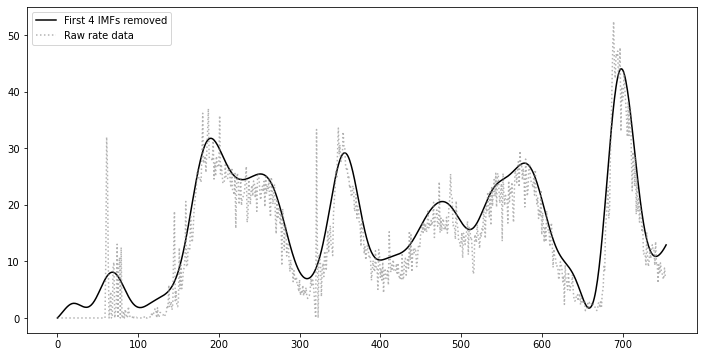

In [211]:
smooth = np.zeros(imf.shape[0])       
for i in np.arange(4, imf.shape[1]):  
    smooth += imf[:, i]

# plot the resulting reconstruction
plt.figure(figsize=(12,6))
plt.plot(smooth + abs(smooth.min()), label='First 4 IMFs removed', color='black')  
plt.plot(x, ':', alpha=0.6, label='Raw rate data', color='grey')                   
plt.legend()
plt.show()

#### Plot the HHT including all IMFs, (original and zoomed)

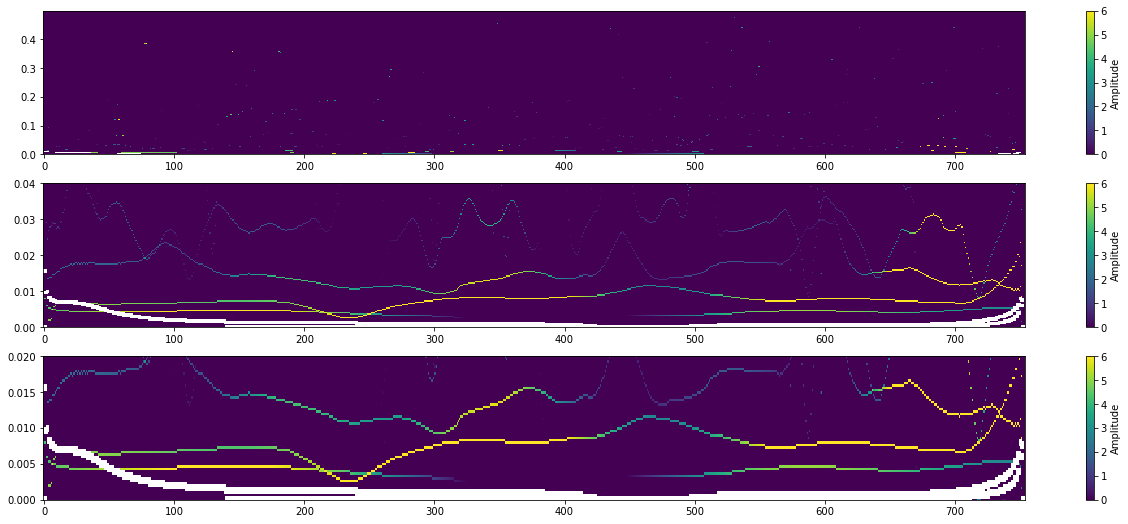

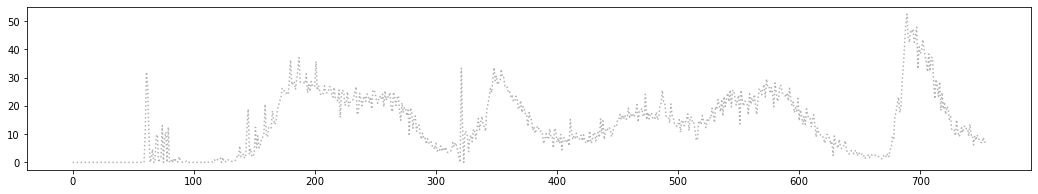

In [239]:
f, hht = emd.spectra.hilberthuang(IF, IA, freq_edges, mode='amplitude', sum_time=False) # now sum_time =False, 1d sum_imfs = false
time_centers = np.arange(len(x))-0.5
#smoothing for visualization
shht = ndimage.gaussian_filter(hht, 0.2)

plt.figure(figsize=(22, 9))
plt.subplots_adjust(wspace=0.3)

plt.subplot(311)
plt.pcolormesh(time_centers, freq_edges[0:-1], shht[:, :len(time_centers)], cmap='viridis', vmin=0, vmax=6)
#plt.ylim(0, 0.1)
cb = plt.colorbar()
cb.set_label('Amplitude', rotation=90)

plt.subplot(312)
plt.pcolormesh(time_centers, freq_edges[0:-1], shht[:, :len(time_centers)], cmap='viridis', vmin=0, vmax=6)
plt.ylim(0, 0.04)
cb = plt.colorbar()
cb.set_label('Amplitude', rotation=90)

plt.subplot(313)
plt.pcolormesh(time_centers, freq_edges[0:-1], shht[:, :len(time_centers)], cmap='viridis', vmin=0, vmax=6)
plt.ylim(0, 0.02)
cb = plt.colorbar()
cb.set_label('Amplitude', rotation=90)

plt.figure(figsize=(18, 3))
plt.plot(x, ':', alpha=0.6, label='Raw rate data', color='grey')
plt.show()
